# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import (binary_classification_metrics, 
                     multiclass_accuracy, 
                     r_squared, 
                     mse, 
                     mae)

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 666
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [4]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

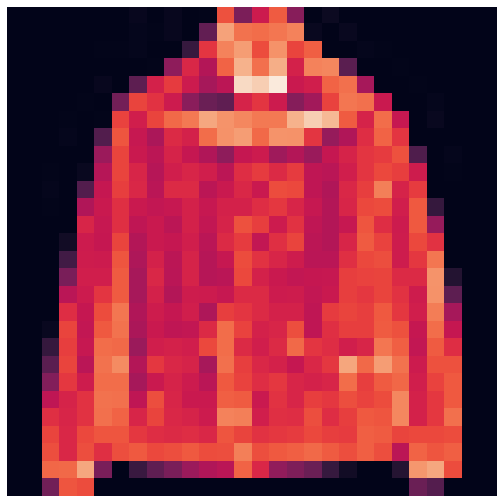

In [5]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

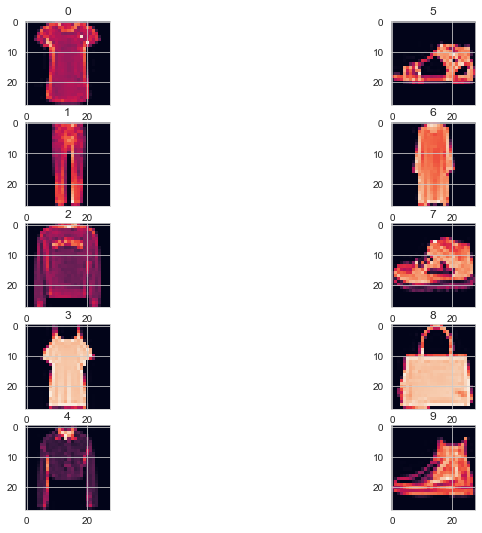

In [6]:
fig, axs = plt.subplots(5, 2)
ten_images = []
for i in range(0, 10):
    axs[i%5, i // 5].imshow(X[y == str(i)][0].reshape(28, 28, 1))
    axs[i%5, i // 5].set_title(i)
plt.show()


### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

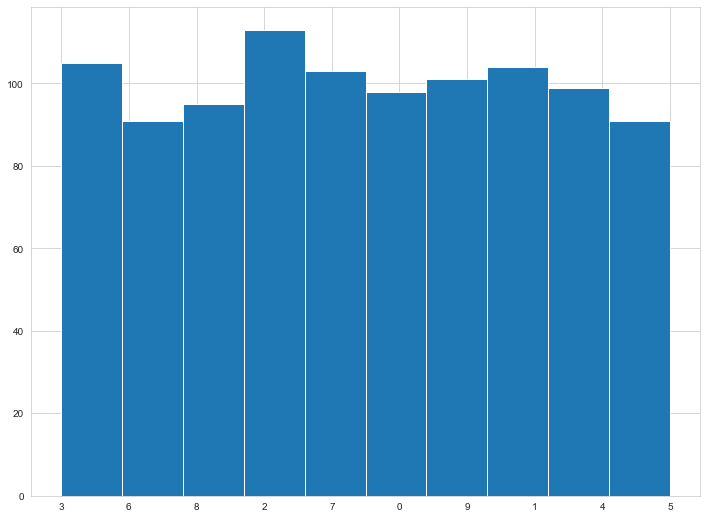

In [7]:
plt.hist(y)
plt.show()

In [8]:
df = pd.DataFrame(y, columns=['class'])
df.rename_axis(index='myindex', inplace=True)
df['count'] = 1
df.head()

,class,count
myindex,,
0,3,1
1,6,1
2,8,1
3,2,1
4,7,1


       count
class       
0         98
1        104
2        113
3        105
4         99
5         91
6         91
7        103
8         95
9        101


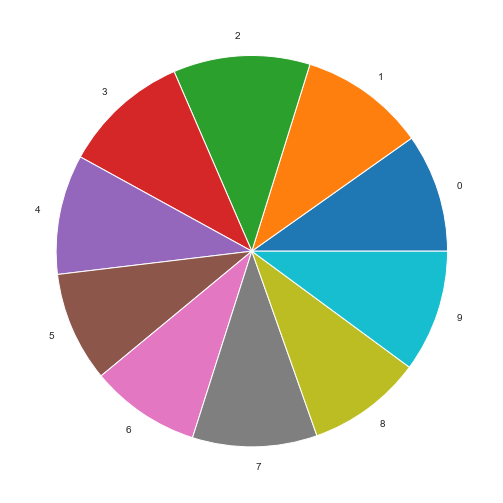

In [9]:
tb1 = pd.pivot_table(df, values= 'count', columns='class', aggfunc=len)
tb1 = tb1.transpose()
tb1.head()
print(tb1)
plt.pie(tb1['count'], labels = tb1.index)
plt.show()

<font size=3 color='purple'><b>Первого графика вполне достаточно</b></font>

<font size=3 color='green'><b>Multiclass EDA outcome: Classes are balanced, no additional data preprocessing required.</b></font>

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [10]:
SEED = 13
random.seed(SEED)
np.random.seed(SEED)
x_train, x_test, y_train, y_test = train_test_split(X, y)
x_train.shape

(750, 784)

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [11]:
binary_criteria = (y_train == '1') | (y_train == '0')
binary_train_y = y_train[binary_criteria].astype(int)
binary_train_X = x_train[binary_criteria]

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

# 1.4.1 EDA for Binary classification

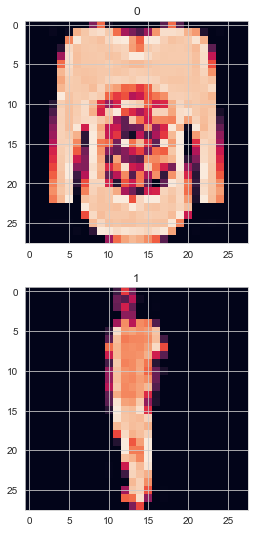

In [12]:
fig, axs = plt.subplots(2, 1)
ten_images = []
for i in range(0, 2):
    axs[i % 2].imshow(binary_train_X[binary_train_y == i][0].reshape(28, 28, 1))
    axs[i % 2].set_title(i)
plt.show()

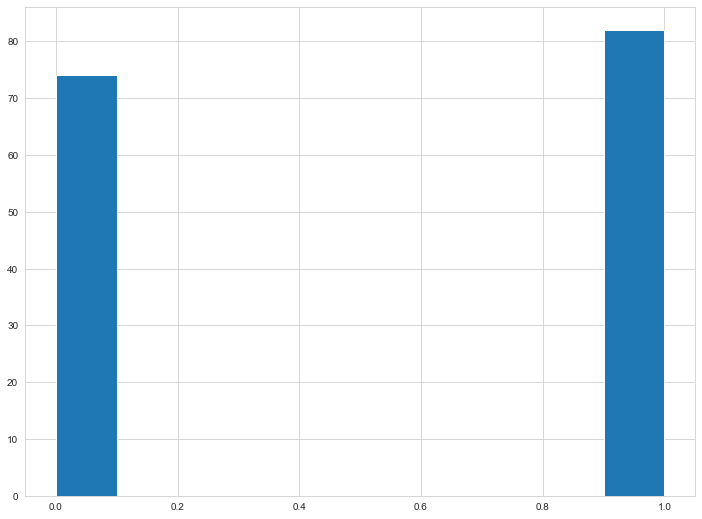

In [13]:
plt.hist(binary_train_y)
plt.show()

In [14]:
df = pd.DataFrame(binary_train_y, columns=['class'])
df.rename_axis(index='myindex', inplace=True)
df['count'] = 1
df.head()

,class,count
myindex,,
0,0,1
1,0,1
2,1,1
3,1,1
4,1,1


       count
class       
0         74
1         82


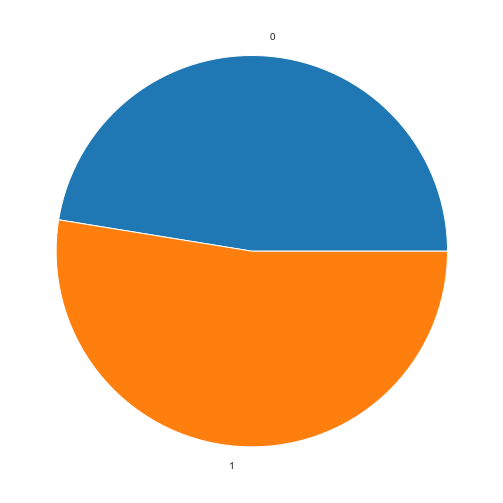

In [15]:
tb1 = pd.pivot_table(df, values= 'count', columns='class', aggfunc=len)
tb1 = tb1.transpose()
tb1.head()
print(tb1)
plt.pie(tb1['count'], labels = tb1.index)
plt.show()

<font size=3 color='purple'><b>Не хватает выводов на основании EDA</b></font>

<font size=3 color='green'><b>Binary EDA outcome: Classes are balanced, no additional data preprocessing required.</b></font>

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [16]:
binary_criteria_test = (y_test == '1') | (y_test == '0')
binary_test_y = y_test[binary_criteria_test].astype(int)
binary_test_X = x_test[binary_criteria_test]

In [17]:
knn_classifier = KNNClassifier(k=5)
knn_classifier.fit(binary_train_X, binary_train_y)

In [18]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [19]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [20]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [21]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loops(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

65.3 ms ± 6.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.95 ms ± 247 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
37.8 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Реализуем метод для предсказания меток класса**

In [22]:
knn_classifier = KNNClassifier(k=20)
knn_classifier.fit(binary_train_X, binary_train_y)

In [23]:
# TODO: predict_labels_binary in knn.py
prediction_binary = knn_classifier.predict(binary_test_X)

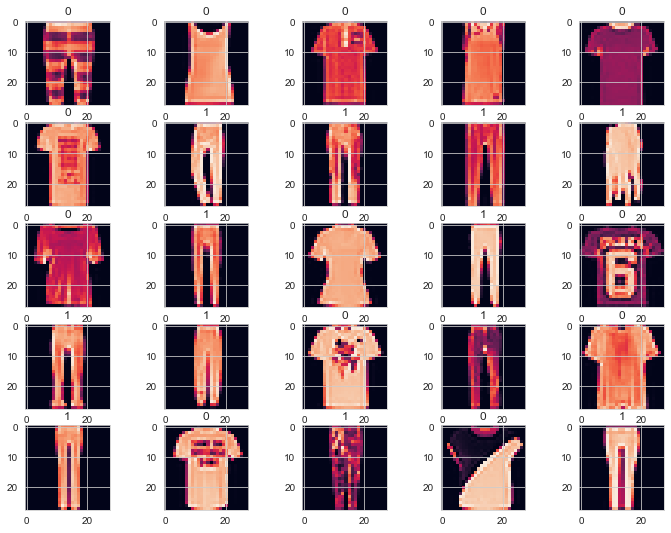

In [24]:
# For binary classification
fig, axs = plt.subplots(5, 5)
ten_images = []
for i in range(0, 25):
    axs[i%5, i // 5].imshow(binary_test_X[i].reshape(28, 28, 1))
    axs[i%5, i // 5].set_title(prediction_binary[i])
plt.show()

In [25]:
knn_classifier = KNNClassifier(k=20)
knn_classifier.fit(x_train, y_train)

In [26]:
# TODO: predict_labels_multiclass in knn.py
prediction_multiclass = knn_classifier.predict(x_test)

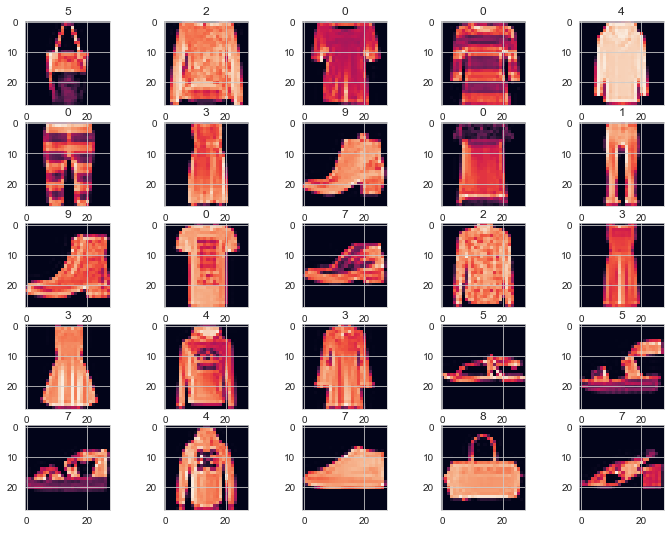

In [27]:
# For multiclass classification
fig, axs = plt.subplots(5, 5)
ten_images = []
for i in range(0, 25):
    axs[i%5, i // 5].imshow(x_test[i].reshape(28, 28, 1))
    axs[i%5, i // 5].set_title(prediction_multiclass[i])
plt.show()

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [28]:
# TODO: binary_classification_metrics in metrics.py

In [29]:
binary_classification_metrics(prediction_binary, binary_test_y)

(0.9130434782608695, 0.95, 0.8636363636363636, 0.9047619047619048)

<font size=3 color='purple'><b>По-хорошему, стоило бы реализовать precision, recall, f1. В задании просили реализовать "несколько метрик", кроме того, в реализации функции multiclass_accuracy1 есть ошибка: ты не объединила в скобки первые два слагаемых np.sum(TP) + np.sum(TN) и по факту у тебя сначала делится np.sum(TN) на общее количество примеров, а потом прибавляется np.sum(TP). Простой sanity check в таком случае: accuracy - это число от 0 до 1. Из-за метрик <font color='red'>-3 балла</font></b></font>

<font size=3 color='green'><b>Mistakes were corrected and additional metrics were made. The bug in multiclass_accuracy1 was fixed.</b></font>

Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [31]:
a_score_value, p_score_value, r_score_value, f1_score_value = binary_classification_metrics(prediction_binary, binary_test_y)

In [32]:
assert np.isclose(p_score_value, precision_score(binary_test_y, prediction_binary))
assert np.isclose(r_score_value, recall_score(binary_test_y, prediction_binary))
assert np.isclose(f1_score_value, f1_score(binary_test_y, prediction_binary))
assert np.isclose(a_score_value, accuracy_score(binary_test_y, prediction_binary))

print(accuracy_score(binary_test_y, prediction_binary, normalize = True))
print(precision_score(binary_test_y, prediction_binary, average = 'binary'))
print(recall_score(binary_test_y, prediction_binary, average = 'binary'))
print(f1_score(binary_test_y, prediction_binary, average = 'binary'))

0.9130434782608695
0.95
0.8636363636363636
0.9047619047619048


### Подбор оптимального k

Чтобы подорбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [33]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """

    train_metrics = []
    test_metrics = []
    for k in params:
        knn_classifier = KNNClassifier(k)
        knn_classifier.fit(X_train, y_train)
        train_metrics.append(metric(y_train, knn_classifier.predict(X_train)))
        test_metrics.append(metric(y_test, knn_classifier.predict(X_test)))
    return train_metrics, test_metrics

In [34]:
params = [1, 2, 4, 5, 8, 9, 10]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, binary_classification_metrics)

In [35]:
print(train_metrics)
print(test_metrics)

[(1.0, 1.0, 1.0, 1.0), (0.9807692307692307, 0.9634146341463414, 1.0, 0.9813664596273292), (0.9743589743589743, 0.9512195121951219, 1.0, 0.975), (0.9743589743589743, 0.9634146341463414, 0.9875, 0.9753086419753086), (0.9807692307692307, 0.9634146341463414, 1.0, 0.9813664596273292), (0.9807692307692307, 0.9634146341463414, 1.0, 0.9813664596273292), (0.9807692307692307, 0.9634146341463414, 1.0, 0.9813664596273292)]
[(1.0, 1.0, 1.0, 1.0), (0.9782608695652174, 0.9545454545454546, 1.0, 0.9767441860465117), (0.9782608695652174, 0.9545454545454546, 1.0, 0.9767441860465117), (0.9782608695652174, 0.9545454545454546, 1.0, 0.9767441860465117), (0.9347826086956522, 0.8636363636363636, 1.0, 0.9268292682926829), (0.9130434782608695, 0.8636363636363636, 0.95, 0.9047619047619048), (0.9347826086956522, 0.8636363636363636, 1.0, 0.9268292682926829)]


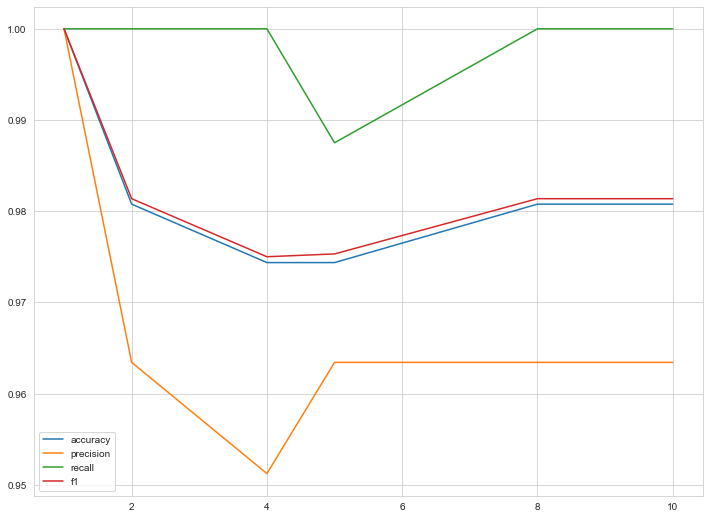

In [36]:
plt.plot(params, train_metrics, label = ['accuracy', 'precision', 'recall', 'f1'])
plt.legend()

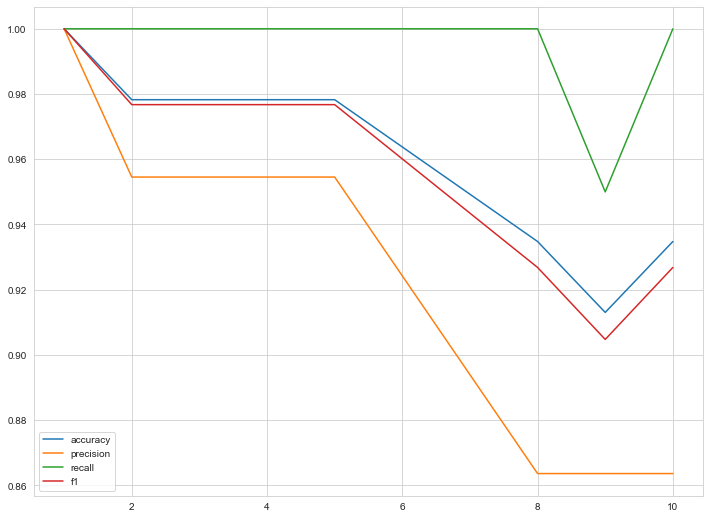

In [37]:
plt.plot(params, test_metrics, label = ['accuracy', 'precision', 'recall', 'f1'])
plt.legend()

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

### **На основании графика для бинарной классификации, можно выбрать, например, k = 5.**

In [38]:
knn_classifier = KNNClassifier(k=5)
knn_classifier.fit(binary_train_X, binary_train_y)
predictions_binary = knn_classifier.predict(binary_test_X)
binary_classification_metrics(predictions_binary, binary_test_y)

(0.9782608695652174, 1.0, 0.9545454545454546, 0.9767441860465117)

### 1.5. Многоклассовая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [39]:
# Let's try the same k=5 for the multiclass classification:
knn_classifier = KNNClassifier(k=5)
knn_classifier.fit(x_train, y_train)
prediction_multiclass = knn_classifier.predict(x_test)
print(prediction_multiclass)

['5', '1', '9', '3', '7', '2', '3', '0', '2', '4', '0', '9', '7', '3', '7', '0', '4', '2', '5', '8', '4', '1', '3', '5', '7', '5', '2', '0', '7', '3', '0', '8', '4', '6', '1', '6', '7', '2', '7', '8', '5', '4', '4', '7', '7', '5', '8', '1', '9', '7', '0', '1', '3', '1', '2', '8', '8', '6', '3', '2', '1', '3', '7', '7', '0', '2', '3', '2', '9', '8', '4', '0', '7', '0', '1', '4', '8', '3', '3', '9', '0', '8', '7', '0', '2', '2', '5', '5', '6', '7', '2', '3', '9', '3', '5', '1', '9', '3', '3', '3', '0', '8', '1', '5', '2', '1', '7', '3', '9', '2', '8', '9', '3', '3', '3', '9', '2', '2', '7', '0', '6', '1', '8', '2', '8', '4', '8', '7', '2', '2', '7', '0', '7', '8', '2', '1', '2', '0', '7', '4', '8', '0', '4', '0', '9', '2', '2', '6', '7', '4', '1', '1', '1', '7', '0', '0', '9', '2', '9', '3', '8', '0', '2', '0', '2', '2', '2', '4', '3', '9', '7', '0', '2', '9', '4', '9', '4', '7', '7', '8', '5', '8', '9', '7', '4', '5', '5', '2', '0', '9', '7', '0', '3', '3', '1', '4', '6', '9', '2', '8',

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [40]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(prediction_multiclass, y_test)

0.752

<font size=3 color='purple'><b>В реализации multiclass_accuracy1 есть ошибка, см. выше. <font color='red'>-1 балл </font></b></font>

<font size=3 color='green'><b>The mistake in the multiclass_accuracy function was fixed.</b></font>

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

In [41]:
params = [1, 2, 3, 4, 5, 8, 9, 10, 13, 16, 18, 22, 25, 30]
train_metrics, test_metrics = find_best_k(x_train, y_train, x_test, y_test, params, multiclass_accuracy)

In [42]:
print(train_metrics)
print(test_metrics)

[1.0, 0.88, 0.8626666666666667, 0.8386666666666667, 0.8466666666666667, 0.812, 0.8013333333333333, 0.8053333333333333, 0.796, 0.792, 0.7826666666666666, 0.7693333333333333, 0.7493333333333333, 0.724]
[0.724, 0.74, 0.76, 0.748, 0.752, 0.736, 0.712, 0.72, 0.708, 0.708, 0.716, 0.696, 0.704, 0.668]


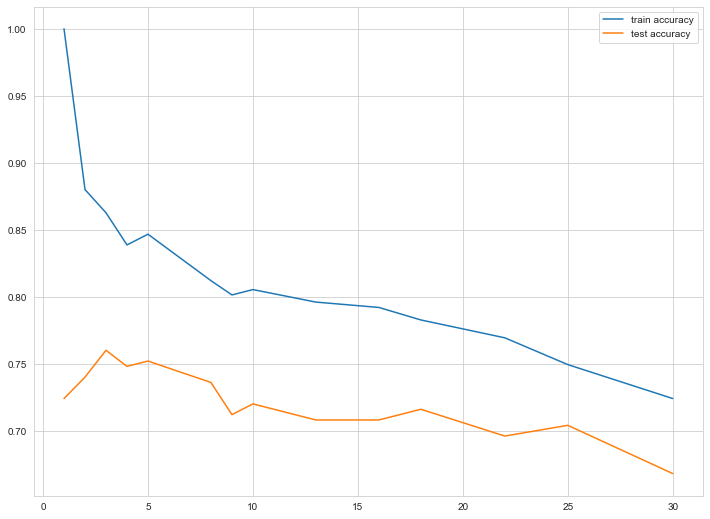

In [43]:
plt.plot(params, train_metrics, label = 'train accuracy')
plt.plot(params, test_metrics, label = 'test accuracy')
plt.legend()

<font size=3 color='purple'><b>Явно где-то ошибка</b></font>

<font size=3 color='green'><b>Looks like the problem was fixed.</b></font>

### **На основании графика для мультиклассовой классификации, можно выбрать, например, k = 2.**

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [44]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [45]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [46]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [47]:
from sklearn.pipeline import Pipeline

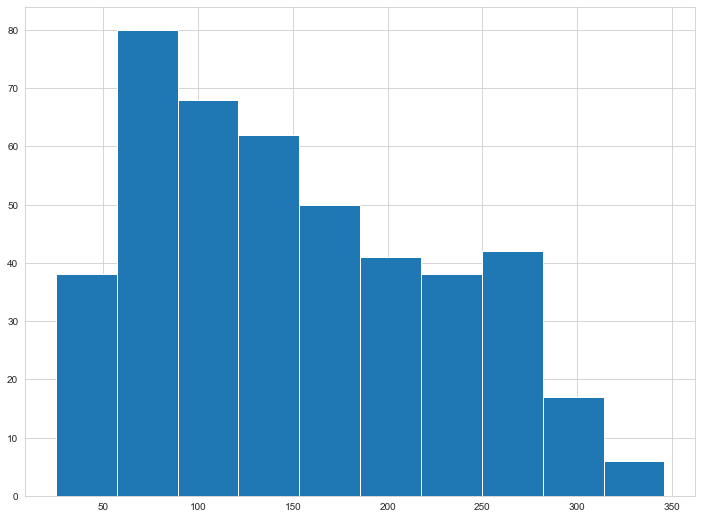

In [48]:
plt.hist(y)
plt.show()

In [49]:
# Checking the missing values in X
X.isnull().sum()

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

In [50]:
# Checking the missing values in y
y.isnull().sum()

0

In [51]:
X.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.639623e-16,1.309912e-16,-8.013951e-16,1.289818e-16,-9.042540e-17,1.301121e-16,-4.563971e-16,3.863174e-16,-3.848103e-16,-3.398488e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


**Looking at the standart deviation parameter of X, it seems that data was already standardized and we can proceed with analysis.**

<font size=3 color='purple'><b>На самом деле средние практически не отличаются, обрати внимание на порядки - эти числа по сути нули. Также в EDA не хватает выводов <font color='red'> -0.5 баллов</font></b></font>

<font size=3 color='green'><b>Conclusion on EDA changed.</b></font>

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [52]:
SEED = 13
random.seed(SEED)
np.random.seed(SEED)
x_train, x_test, y_train, y_test = train_test_split(X, y)
x_test.shape

(111, 10)

In [53]:
x_test.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
135,-0.005515,-0.044642,0.056307,-0.036656,-0.048351,-0.042963,-0.072854,0.037999,0.050782,0.056912
358,-0.020045,-0.044642,-0.084886,-0.026328,-0.035968,-0.034194,0.041277,-0.051671,-0.082381,-0.046641
194,-0.067268,-0.044642,-0.059019,0.032201,-0.051103,-0.049539,-0.010266,-0.039493,0.002008,0.023775
399,0.059871,0.050680,0.022895,0.049415,0.016318,0.011838,-0.013948,-0.002592,0.039540,0.019633
405,0.048974,0.050680,0.123131,0.083844,-0.104765,-0.100895,-0.069172,-0.002592,0.036646,-0.030072


In [54]:
# Create model
regressorKN = KNeighborsRegressor(n_neighbors=5)

In [55]:
regressorKN.fit(x_train, y_train)

KNeighborsRegressor()

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [56]:
# TODO: r_squared, mse, mae in metrics.py

In [57]:
# r_squared function
print(r_squared(regressorKN.predict(x_test), y_test))

0.444839446741765


In [58]:
# mse function
print(mse(regressorKN.predict(x_test), y_test))

2922.92864864865


In [59]:
# mae function
print(mae(regressorKN.predict(x_test), y_test))

41.72792792792792


<font size=3 color='purple'><b>Непонятный нейминг функций, зачем эта единичка в конце?</b></font>

<font size=3 color='green'><b>FIXED</b></font>

**Let's validate our results using sklearn functions!**

In [60]:
# R2 score for closest neighbors parameter = 5:
print(r2_score(y_test, regressorKN.predict(x_test)))

0.44483944674176545


In [61]:
# MSE for closest neighbors parameter = 5:
print(mean_squared_error(y_test, regressorKN.predict(x_test)))

2922.928648648649


In [62]:
# MAE for closest neighbors parameter = 5:
print(mean_absolute_error(y_test, regressorKN.predict(x_test)))

41.72792792792793


![alt text](https://eserioblog.files.wordpress.com/2014/02/borat.jpg "Great success!")

### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [63]:
from metrics import r_squared, mse, mae

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше.

In [64]:
def find_best_k2(X_train, y_train, X_test, y_test, params, function):
    scores = [0] * 31
    for k in params:
        regressorKN = KNeighborsRegressor(n_neighbors=k)
        pipelineRG = Pipeline(steps = [('regression', regressorKN)])
        pipelineRG.fit(X_train, y_train)
        scores[k] = function(pipelineRG.predict(X_test), y_test)
    return scores

In [65]:
# params = [1, 2, 3, 4, 5, 8, 9, 10, 15, 30]
params = list(range(1,30))

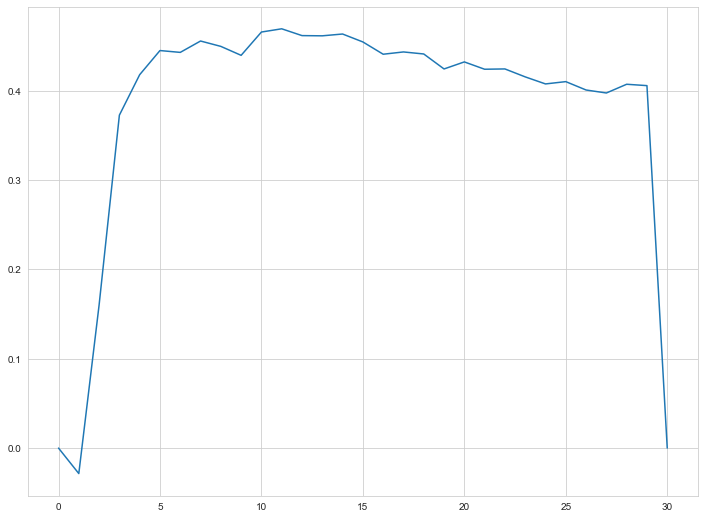

In [66]:
# Plot for r_squared:
plt.plot(find_best_k2(x_train, y_train, x_test, y_test, params, r_squared))

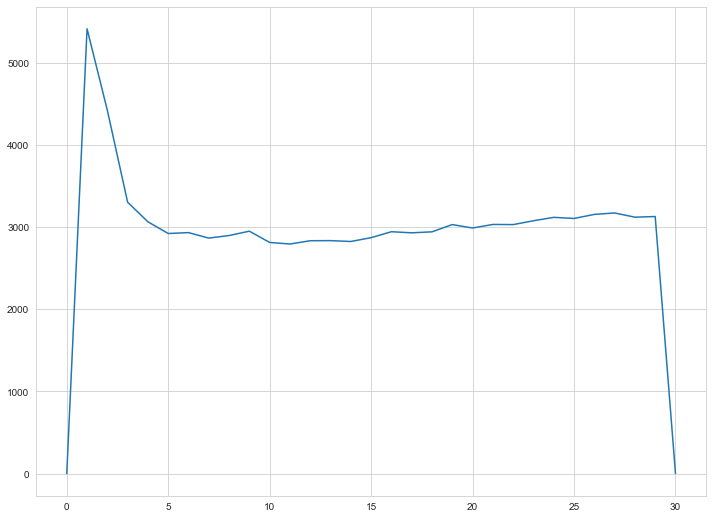

In [67]:
# Plot for Mean squared error (MSE):
plt.plot(find_best_k2(x_train, y_train, x_test, y_test, params, mse))

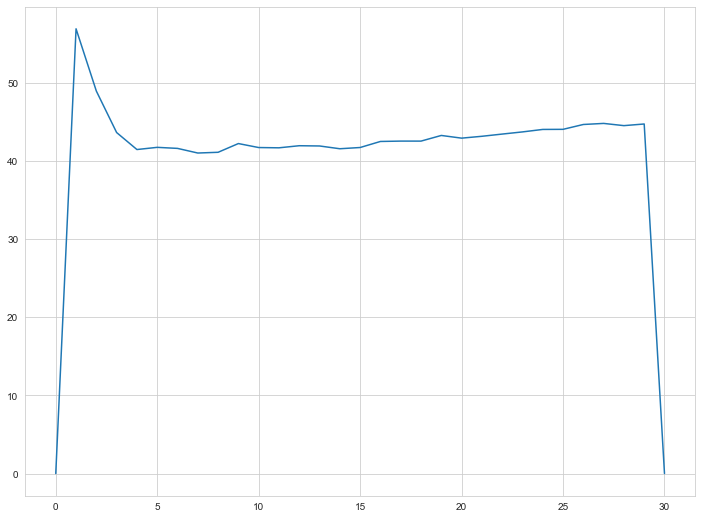

In [68]:
# Plot for Mean absolute error (MAE):
plt.plot(find_best_k2(x_train, y_train, x_test, y_test, params, mae))

### **На основании графиков для r_squared (максимальное значение), Mean squared error (MSE)/Mean absolute error (MAE) (наименьшие значения), можно выбрать, например, k = 11.**

**Let's use Grid Search instrument from sklearn to find the best parameter and check our results.**

In [69]:
parameters_gridRG = {'n_neighbors': list(range(1,30))}

In [70]:
grid_RG = GridSearchCV(regressorKN, parameters_gridRG, scoring = 'r2')

In [71]:
grid_RG.fit(x_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29]},
             scoring='r2')

In [72]:
grid_RG.best_params_

{'n_neighbors': 18}

In [73]:
print(r2_score(y_test, grid_RG.best_estimator_.predict(x_test)))

0.44100438867500047


### **Suddenly, Grid Search predicted best number of closest neighbors as 18.**

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме (желательно, чтобы были люди и с Онлайна, и с Питера), познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

![alt text](http://img4.imagetitan.com/img4/small/24/24_images358.jpg "Title")

<font size=3 color='purple'><b>Так не прокатит :)</b></font>

![alt text](http://img4.imagetitan.com/img4/small/24/24_123210.png "Me at all meetings")

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Вопрос: Почему параметры precision_score, recall_score и f1_score сливаются в единую линию на графике для мультиклассовой классификации? 

<font size=3 color='purple'><b>Итого: <font color='green'>6 (1я часть) + 9.5 (2я часть) + 2 (за Pipeline) = 17.5 </font></b></font>